In [ ]:
# PARTE 1: DESCARGA Y PREPARACIÓN DEL DATASET

# Librerías
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
# DESCARGA DEL DATASET DESDE KAGGLEHUB

import kagglehub
import os

try:
    # Descargar el dataset
    path = kagglehub.dataset_download("feyzazkefe/trashnet")
    print(f" Dataset descargado correctamente en:\n{path}")

    # Verificar estructura
    print("\n Contenido del dataset:")
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f"{subindent}{f}")
except Exception as e:
    print(f" Error al descargar el dataset: {e}")


100%|██████████| 40.8M/40.8M [00:00<00:00, 133MB/s]

Extracting files...


 Dataset descargado correctamente en:
/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1

 Contenido del dataset:
1/
    dataset-resized/
        trash/
            trash84.jpg
            trash13.jpg
            trash133.jpg
            trash57.jpg
            trash64.jpg
            trash6.jpg
            trash59.jpg
            trash101.jpg
            trash4.jpg
            trash50.jpg
            trash3.jpg
            trash107.jpg
            trash126.jpg
            trash118.jpg
            trash19.jpg
            trash32.jpg
            trash104.jpg
            trash134.jpg
            trash58.jpg
            trash49.jpg
            trash52.jpg
            trash119.jpg
            trash24.jpg
            trash29.jpg
            trash82.jpg
            trash34.jpg
            trash41.jpg
            trash83.jpg
            trash73.jpg
            trash60.jpg
            trash91.jpg
            trash93.jpg
            trash97.jpg
            trash33.jpg
            tr

In [ ]:
# PARTE 2: CREACIÓN DE GENERADORES DE IMÁGENES

import os

base_dir = "/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized"

if not os.path.exists(base_dir):
    print(f"Error: El directorio base '{base_dir}' no existe. Por favor, verifica la ruta.")
else:
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode="categorical",
        subset="training"
    )

    val_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode="categorical",
        subset="validation"
    )

    print("Clases detectadas:", train_generator.class_indices)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Clases detectadas: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [ ]:
# PARTE 3: MODELO CNN PARA CLASIFICACIÓN DE RESIDUOS

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Definir la arquitectura de la CNN
model = Sequential([
    # Bloque 1
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Bloque 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Bloque 3
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Clasificador
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen
model.summary()

# ENTRENAMIENTO DEL MODELO

# Early stopping para evitar sobreajuste
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,310 (12.61 MB)

 Trainable params: 3,305,862 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 313ms/step - accuracy: 0.3753 - loss: 2.4598 - val_accuracy: 0.0736 - val_loss: 2.5625
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.5591 - loss: 1.2377 - val_accuracy: 0.1034 - val_loss: 3.5213
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.5773 - loss: 1.1997 - val_accuracy: 0.1909 - val_loss: 2.9260
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.6147 - loss: 1.0612 - val_accuracy: 0.2207 - val_loss: 2.9676
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.6311 - loss: 0.9988 - val_accuracy: 0.2763 - val_loss: 1.9312
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.6348 - loss: 1.0064 - val_accuracy: 0.3718 - val_loss: 1.6736
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.6316 - loss: 0.9547 - val_accuracy: 0.4632 - val_loss: 1.4135
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.6635 - loss: 0.9368 - val_accu

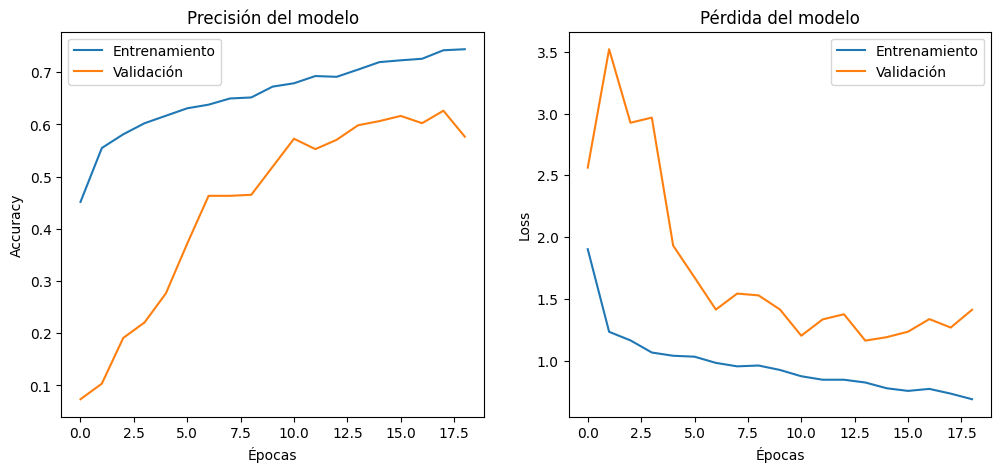

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.6465 - loss: 1.0683

Precisión final en validación: 60.83%


In [ ]:
# PARTE 4: EVALUACIÓN Y VISUALIZACIÓN

import matplotlib.pyplot as plt

# Gráficos de precisión y pérdida
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluar en el conjunto de validación
val_loss, val_acc = model.evaluate(val_generator)
print(f"\nPrecisión final en validación: {val_acc:.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step


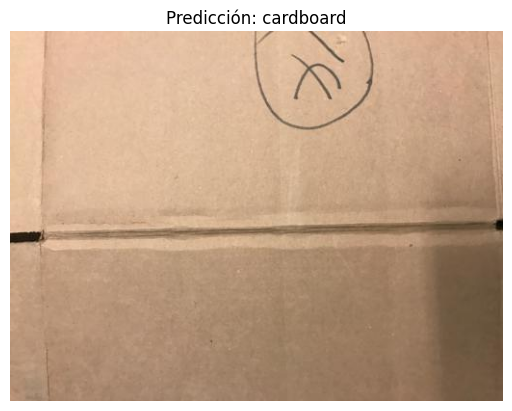

📸 La red neuronal predice que la imagen es: **CARDBOARD**
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


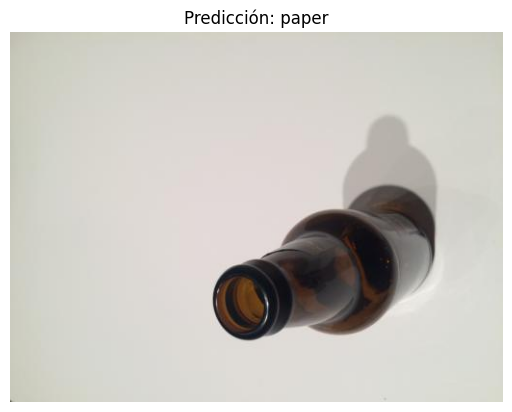

📸 La red neuronal predice que la imagen es: **PAPER**
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


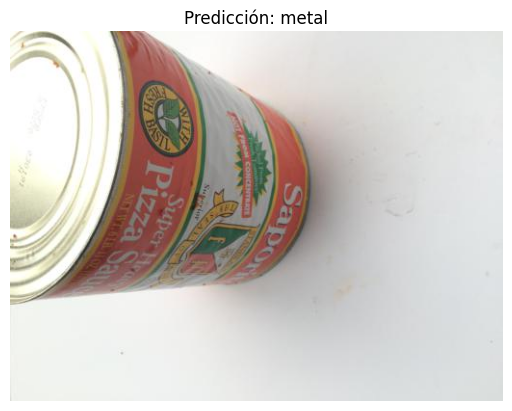

📸 La red neuronal predice que la imagen es: **METAL**
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


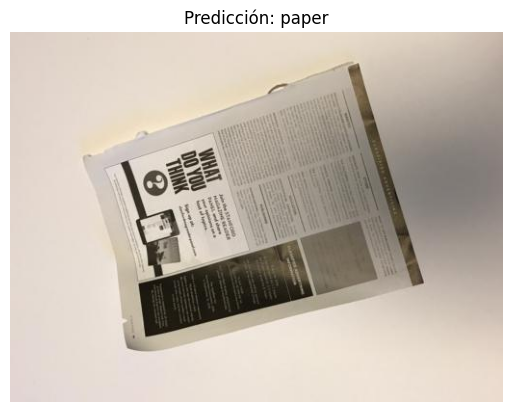

📸 La red neuronal predice que la imagen es: **PAPER**
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


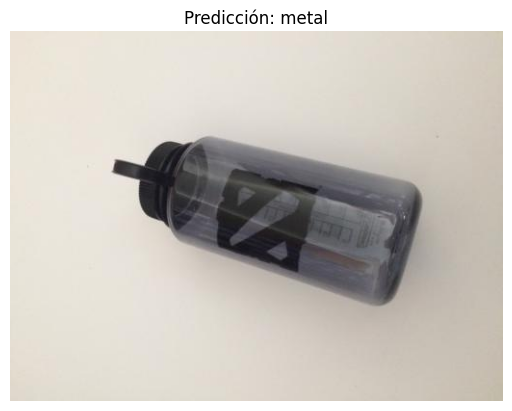

📸 La red neuronal predice que la imagen es: **METAL**
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


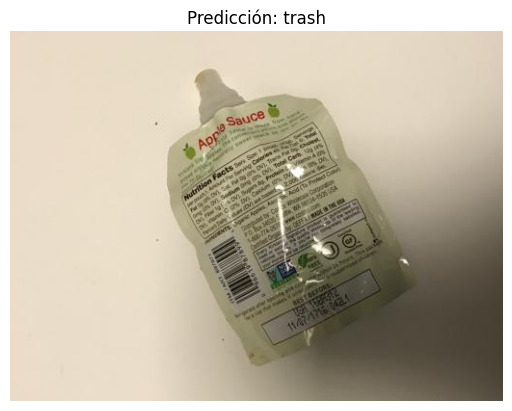

📸 La red neuronal predice que la imagen es: **TRASH**
---


In [ ]:
# PREDICCIÓN CON MÚLTIPLES IMÁGENES

import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

image_paths = [
    '/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/cardboard/cardboard1.jpg',
    '/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/glass/glass1.jpg',
    '/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/metal/metal1.jpg',
    '/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/paper/paper1.jpg',
    '/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/plastic/plastic1.jpg',
    '/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/trash/trash1.jpg',
]

if not image_paths:
    print("No hay rutas de imágenes en la lista 'image_paths'. Por favor, agrega algunas rutas para realizar predicciones.")
else:
    # Asegúrate de que train_generator esté definido antes de usarlo
    if 'train_generator' not in globals():
        print("Error: 'train_generator' no está definido. Por favor, ejecuta la celda que crea los generadores de imágenes primero.")
    else:
        for img_path in image_paths:
            if not os.path.exists(img_path):
                print(f"Error: La imagen '{img_path}' no se encontró. Saltando...")
                continue

            try:
                # Cargar y preprocesar la imagen
                img = image.load_img(img_path, target_size=(128, 128))
                img_array = image.img_to_array(img) / 255.0
                img_array = np.expand_dims(img_array, axis=0)  # convertir a batch

                # Realizar predicción
                pred = model.predict(img_array)
                pred_class_index = np.argmax(pred, axis=1)[0]

                # Obtener nombre de la clase
                class_labels = {v: k for k, v in train_generator.class_indices.items()}
                predicted_label = class_labels[pred_class_index]

                # Mostrar resultado
                plt.imshow(image.load_img(img_path))
                plt.axis("off")
                plt.title(f"Predicción: {predicted_label}")
                plt.show()

                print(f"📸 La red neuronal predice que la imagen es: **{predicted_label.upper()}**\n---")

            except Exception as e:
                print(f"Error al procesar la imagen '{img_path}': {e}\n---")

Saving mine_carton.png to mine_carton.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


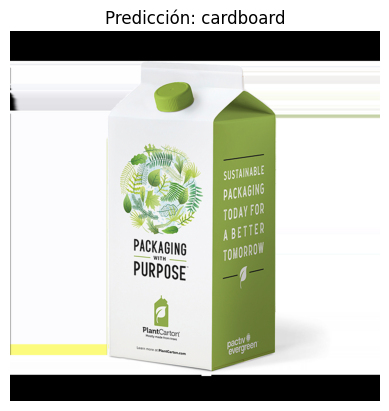

📸 La red neuronal predice que la imagen es: **CARDBOARD**


In [ ]:
# PARTE 5: PREDICCIÓN CON IMÁGENES NUEVAS

import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Subir una imagen desde tu computadora
from google.colab import files
uploaded = files.upload()

# Obtener el nombre del archivo subido
img_path = list(uploaded.keys())[0]

# Cargar y preprocesar la imagen
img = image.load_img(img_path, target_size=(128,128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # convertir a batch

# Realizar predicción
pred = model.predict(img_array)
pred_class_index = np.argmax(pred, axis=1)[0]

# Obtener nombre de la clase
class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_label = class_labels[pred_class_index]

# Mostrar resultado
plt.imshow(image.load_img(img_path))
plt.axis("off")
plt.title(f"Predicción: {predicted_label}")
plt.show()

print(f"📸 La red neuronal predice que la imagen es: **{predicted_label.upper()}**")


In [12]:
model.save("trashnet_cnn_model.h5")


In [13]:
from tensorflow.keras.models import load_model
model = load_model("trashnet_cnn_model.h5")


In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model
model_transfer = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the new model
model_transfer.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the summary of the new model
model_transfer.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,166 (60.14 MB)

 Trainable params: 1,049,478 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
history_transfer = model_transfer.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25, # Use a reasonable number of epochs for initial training
    callbacks=[early_stop]
)

Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 357ms/step - accuracy: 0.3860 - loss: 1.5772 - val_accuracy: 0.5288 - val_loss: 1.2309
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - accuracy: 0.6464 - loss: 1.0196 - val_accuracy: 0.5507 - val_loss: 1.1308
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.6913 - loss: 0.8741 - val_accuracy: 0.6024 - val_loss: 1.0563
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.7243 - loss: 0.7878 - val_accuracy: 0.6441 - val_loss: 1.0175
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - accuracy: 0.7538 - loss: 0.7291 - val_accuracy: 0.6481 - val_loss: 0.9420
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 228ms/step - accuracy: 0.7486 - loss: 0.6945 - val_accuracy: 0.6461 - val_loss: 0.9341
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step - accuracy: 0.7768 - loss: 0.6574 - val_accuracy: 0.6600 - val_loss: 0.9378
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 225ms/step - accuracy: 0.7985 - loss: 0.5948 - val_accu

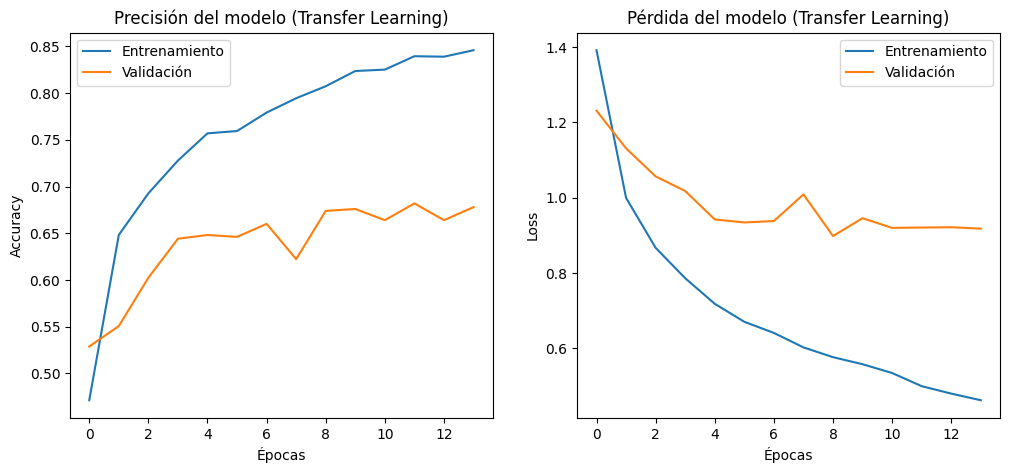

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.6598 - loss: 0.9297

Precisión final en validación (Transfer Learning): 66.00%
Pérdida final en validación (Transfer Learning): 0.9114


In [ ]:
# EVALUACIÓN Y VISUALIZACIÓN DEL MODELO DE TRANSFER LEARNING

import matplotlib.pyplot as plt

# Gráficos de precisión y pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='Entrenamiento')
plt.plot(history_transfer.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo (Transfer Learning)')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='Entrenamiento')
plt.plot(history_transfer.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo (Transfer Learning)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluar en el conjunto de validación
if 'val_generator' not in globals():
    print("Error: 'val_generator' no está definido. Por favor, ejecuta la celda que crea los generadores de imágenes primero.")
else:
    val_loss_transfer, val_acc_transfer = model_transfer.evaluate(val_generator)
    print(f"\nPrecisión final en validación (Transfer Learning): {val_acc_transfer:.2%}")
    print(f"Pérdida final en validación (Transfer Learning): {val_loss_transfer:.4f}")

In [ ]:
# AJUSTE FINO DEL MODELO DE TRANSFER LEARNING

fine_tune_at = 15 # Descongelar a partir de la capa 15 (las últimas 4 capas convolucionales)

# Congelar todas las capas del modelo base inicialmente (esto ya se hizo antes, pero lo repetimos por claridad)
for layer in model_transfer.layers[0].layers:
    layer.trainable = False

# Descongelar las capas a partir de 'fine_tune_at'
for layer in model_transfer.layers[0].layers[fine_tune_at:]:
    layer.trainable = True

# Recompilar el modelo con una tasa de aprendizaje más baja
# Una tasa de aprendizaje muy baja es crucial para el ajuste fino
model_transfer.compile(
    optimizer=Adam(learning_rate=0.00001), # Tasa de aprendizaje más baja
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_transfer.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,166 (60.14 MB)

 Trainable params: 8,128,902 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## Continuar Entrenamiento con Ajuste Fino

Ahora entrenaremos el modelo nuevamente por algunas épocas adicionales con las capas descongeladas y la tasa de aprendizaje baja.

In [ ]:
# CONTINUAR ENTRENAMIENTO CON AJUSTE FINO

fine_tune_epochs = 10
total_epochs =  len(history_transfer.history['accuracy']) + fine_tune_epochs # Continuar desde donde terminó el entrenamiento anterior


history_fine_tune = model_transfer.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    initial_epoch=history_transfer.epoch[-1] + 1, # Continuar desde la última época del entrenamiento anterior
    callbacks=[early_stop]
)

# Combinar historiales de entrenamiento para visualización posterior
history_combined = {}
for key in history_transfer.history.keys():
    history_combined[key] = history_transfer.history[key] + history_fine_tune.history[key]

Epoch 15/24
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 326ms/step - accuracy: 0.8225 - loss: 0.5056 - val_accuracy: 0.6978 - val_loss: 0.8644
Epoch 16/24
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 259ms/step - accuracy: 0.8484 - loss: 0.4400 - val_accuracy: 0.6938 - val_loss: 0.8704
Epoch 17/24
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.8610 - loss: 0.3951 - val_accuracy: 0.7197 - val_loss: 0.8720
Epoch 18/24
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step - accuracy: 0.8814 - loss: 0.3515 - val_accuracy: 0.7117 - val_loss: 0.8716
Epoch 19/24
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - accuracy: 0.9015 - loss: 0.3047 - val_accuracy: 0.6978 - val_loss: 0.8790
Epoch 20/24
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy: 0.9108 - loss: 0.2880 - val_accuracy: 0.7097 - val_loss: 0.8771


## Evaluación y Visualización después del Ajuste Fino

Después de completar el ajuste fino, evaluaremos el rendimiento del modelo nuevamente y visualizaremos el historial de entrenamiento combinado.

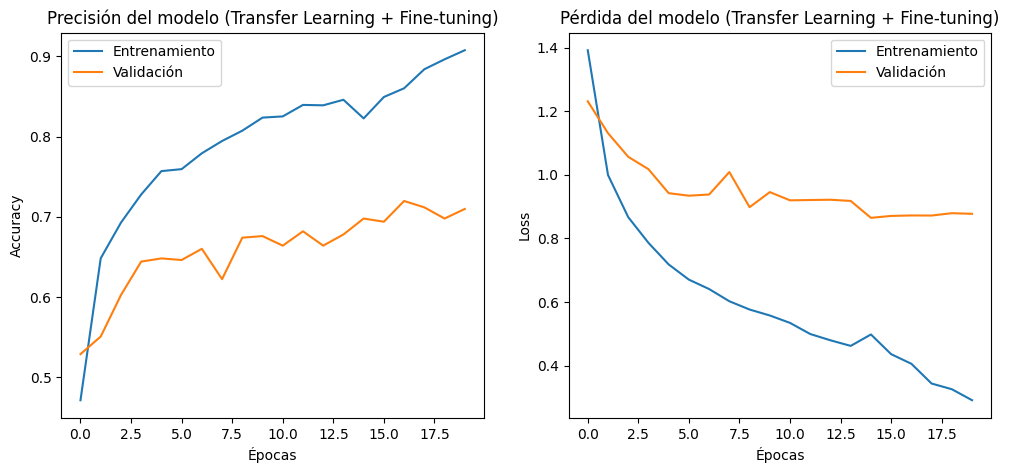

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.6938 - loss: 0.8525

Precisión final en validación (Transfer Learning + Fine-tuning): 69.58%
Pérdida final en validación (Transfer Learning + Fine-tuning): 0.8378


In [ ]:
import matplotlib.pyplot as plt

# Gráficos de precisión y pérdida combinados
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_combined['accuracy'], label='Entrenamiento')
plt.plot(history_combined['val_accuracy'], label='Validación')
plt.title('Precisión del modelo (Transfer Learning + Fine-tuning)')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_combined['loss'], label='Entrenamiento')
plt.plot(history_combined['val_loss'], label='Validación')
plt.title('Pérdida del modelo (Transfer Learning + Fine-tuning)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluar en el conjunto de validación
# Asegúrate de que val_generator esté definido
if 'val_generator' not in globals():
    print("Error: 'val_generator' no está definido. Por favor, ejecuta la celda que crea los generadores de imágenes primero.")
else:
    val_loss_fine_tune, val_acc_fine_tune = model_transfer.evaluate(val_generator)
    print(f"\nPrecisión final en validación (Transfer Learning + Fine-tuning): {val_acc_fine_tune:.2%}")
    print(f"Pérdida final en validación (Transfer Learning + Fine-tuning): {val_loss_fine_tune:.4f}")

## Hiperparámetros Clave a Optimizar

Basándonos en la arquitectura y el proceso de entrenamiento implementado (Transfer Learning con Ajuste Fino), los hiperparámetros clave en los que podríamos enfocarnos para mejorar el rendimiento son:

1.  **Tasa de Aprendizaje (Learning Rate) para el Ajuste Fino:** Este es uno de los hiperparámetros más críticos. Durante el ajuste fino, usamos una tasa de aprendizaje muy baja (`0.00001`). Experimentar con valores ligeramente diferentes (más altos o más bajos, por ejemplo, `0.000005`, `0.00002`) puede tener un impacto significativo.
2.  **Número de Épocas para el Ajuste Fino:** Definimos un número fijo de épocas (`fine_tune_epochs = 10`), pero el Early Stopping limita el entrenamiento si no hay mejora. Podríamos definir un número máximo de épocas mayor para permitir que el proceso de Early Stopping encuentre el mejor punto de parada.
3.  **Número de Capas a Descongelar (`fine_tune_at`):** Actualmente descongelamos las últimas 4 capas convolucionales (`fine_tune_at = 15`). Probar a descongelar más o menos capas del modelo base (por ejemplo, `fine_tune_at = 11` para descongelar un bloque convolucional más, o `fine_tune_at = 18` para descongelar menos) puede afectar qué tan bien se adapta el modelo a tu dataset. Descongelar demasiadas capas al inicio puede llevar a que el modelo "olvide" lo que aprendió en ImageNet (sobreajuste en las primeras épocas), mientras que descongelar muy pocas puede limitar su capacidad de adaptación.
4.  **Regularización (Dropout Rate):** Tenemos una capa Dropout con un rate de `0.4` en el clasificador. Ajustar este valor (por ejemplo, `0.3`, `0.5`) podría ayudar a controlar el sobreajuste.
5.  **Parámetros del Optimizador (Adam):** Aunque Adam suele ser robusto, se podría experimentar ligeramente con sus parámetros beta o epsilon, aunque la tasa de aprendizaje es generalmente el más importante a ajustar primero.

El objetivo del ajuste de hiperparámetros es probar diferentes combinaciones de estos valores y encontrar la que produzca la mejor precisión en el conjunto de validación sin caer en el sobreajuste.